#### Dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import nfl_data_py as nfl

### Loading the Data

In [2]:
# Turn off pandas column limit
pd.set_option('display.max_columns', None)

In [3]:
# Read in the tracking data
raw_tracking = pd.read_csv("data/tracking_week_1.csv")

In [4]:
# Read in other data to use later
players = pd.read_csv("data/players.csv")
plays = pd.read_csv("data/plays.csv")

In [5]:
# Copy the DataFrame
tracking = raw_tracking.copy()

In [6]:
tracking.head()

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
0,2022090800,56,35472.0,Rodger Saffold,1,2022-09-08 20:24:05.200000,76.0,BUF,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN
1,2022090800,56,35472.0,Rodger Saffold,2,2022-09-08 20:24:05.299999,76.0,BUF,left,88.47,27.13,1.67,0.61,0.17,230.98,148.53,pass_arrived
2,2022090800,56,35472.0,Rodger Saffold,3,2022-09-08 20:24:05.400000,76.0,BUF,left,88.56,27.01,1.57,0.49,0.15,230.98,147.05,NaN
3,2022090800,56,35472.0,Rodger Saffold,4,2022-09-08 20:24:05.500000,76.0,BUF,left,88.64,26.90,1.44,0.89,0.14,232.38,145.42,NaN
4,2022090800,56,35472.0,Rodger Saffold,5,2022-09-08 20:24:05.599999,76.0,BUF,left,88.72,26.80,1.29,1.24,0.13,233.36,141.95,NaN


#### When do defenders commit to a path to intercept the ball carrier?

In [7]:
len(tracking)

1407439

In [8]:
# Value count of event
tracking['event'].value_counts()

event
first_contact                28773
tackle                       26928
ball_snap                    16415
pass_outcome_caught          15870
handoff                      15364
pass_arrived                 13915
out_of_bounds                 5037
run                           2737
man_in_motion                 1288
play_action                   1035
touchdown                     1012
fumble                         621
shift                          368
qb_slide                       350
pass_forward                   248
snap_direct                     46
line_set                        46
lateral                         45
autoevent_ballsnap              30
run_pass_option                 23
qb_sack                         23
pass_shovel                     23
fumble_defense_recovered        23
fumble_offense_recovered        23
autoevent_passinterrupted       16
autoevent_passforward            9
Name: count, dtype: int64

Let's filter plays down to when the ball carrier receives that ball. We'll do this by keeping identifying frames within a gameId, playId combination that are greater than the frameId where event_type is in pass_outcome_caught or handoff. Since the theme of this competition is tackling, this allows us to isolate the actions that the players take when the primary objective is __tackling__, rather than figuring out where the ball is going.

In [9]:
# For each gameId and playId combination, identify the frameId where the event 'pass_outcome_caught' or 'handoff' occurs
tracking['ballArrivedFrame'] = tracking.groupby(['gameId', 'playId'])['frameId']\
                                .transform(lambda x: x[tracking['event']\
                                    .isin(['pass_outcome_caught', 'handoff'])]\
                                        .min())

In [10]:
# TODO: Make sure there's no other event_type values that indicate a ball carrier receiving the ball
# TODO: i.e. a QB scramble or something else I'm not thinking of, and verify what pass_arrived means

# Drop any rows where the ballArrivedFrame is null for the entire playId, gameId combination
# - this eliminates any plays that don't have the possibility of a tackle
tracking = tracking[tracking.groupby(['gameId', 'playId'])['ballArrivedFrame'].transform('any')]

All remaining play events occur after the snap and after the ball carrier receives the ball.

In [11]:
tracking['event'].value_counts()

event
first_contact                26818
tackle                       25185
pass_outcome_caught          15870
handoff                      15364
ball_snap                    15242
pass_arrived                 13915
out_of_bounds                 4508
man_in_motion                 1288
touchdown                      897
fumble                         552
play_action                    460
shift                          368
pass_forward                   226
line_set                        46
autoevent_ballsnap              30
pass_shovel                     23
fumble_defense_recovered        23
lateral                         22
autoevent_passinterrupted       15
autoevent_passforward            8
Name: count, dtype: int64

In [12]:
# For each gameId, playId combination, drop any rows where frameId is less than ballArrivedFrame
tracking = tracking[tracking['frameId'] >= tracking.groupby(['gameId', 'playId'])['ballArrivedFrame'].transform('first')]

In [13]:
# Number of plays where a tackle is possible
len(tracking['playId'].unique())

1162

Next, we need to identify the point after the ball carrier receives the ball where the defense makes the biggest adjustment. This identifies:

1) The path they've decided to take in order to run down the ball carrier
2) Their execution on this decision

In [14]:
# First, let's merge the tracking data with the plays data to identify the defensive team
df = tracking.merge(plays, on=['gameId', 'playId'], how='left')

In [15]:
# Next let's keep only the rows where club == defensiveTeam
df = df[df['club'] == df['defensiveTeam']]

In [16]:
df.head()

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,ballArrivedFrame,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,passResult,passLength,penaltyYards,prePenaltyPlayResult,playResult,playNullifiedByPenalty,absoluteYardlineNumber,offenseFormation,defendersInTheBox,passProbability,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2
17,2022090800,56,38577.0,Bobby Wagner,6,2022-09-08 20:24:05.700000,45.0,LA,left,78.11,28.74,3.35,2.62,0.32,349.47,357.71,pass_outcome_caught,6.0,42489,Stefon Diggs,(15:00) (Shotgun) J.Allen pass short right to ...,1,1,10,BUF,LA,BUF,25,15:00,0,0,C,5.0,NaN,6,6,N,85,SHOTGUN,6.0,0.68996,0.413347,0.586653,-0.000031,0.000031,1.298699,0.00442,NaN,NaN,NaN,NaN
18,2022090800,56,38577.0,Bobby Wagner,7,2022-09-08 20:24:05.799999,45.0,LA,left,78.10,29.08,3.52,1.83,0.34,345.22,359.37,NaN,6.0,42489,Stefon Diggs,(15:00) (Shotgun) J.Allen pass short right to ...,1,1,10,BUF,LA,BUF,25,15:00,0,0,C,5.0,NaN,6,6,N,85,SHOTGUN,6.0,0.68996,0.413347,0.586653,-0.000031,0.000031,1.298699,0.00442,NaN,NaN,NaN,NaN
19,2022090800,56,38577.0,Bobby Wagner,8,2022-09-08 20:24:05.900000,45.0,LA,left,78.10,29.44,3.65,1.16,0.36,342.21,0.37,NaN,6.0,42489,Stefon Diggs,(15:00) (Shotgun) J.Allen pass short right to ...,1,1,10,BUF,LA,BUF,25,15:00,0,0,C,5.0,NaN,6,6,N,85,SHOTGUN,6.0,0.68996,0.413347,0.586653,-0.000031,0.000031,1.298699,0.00442,NaN,NaN,NaN,NaN
20,2022090800,56,38577.0,Bobby Wagner,9,2022-09-08 20:24:06.000000,45.0,LA,left,78.11,29.80,3.65,0.61,0.36,343.38,1.93,NaN,6.0,42489,Stefon Diggs,(15:00) (Shotgun) J.Allen pass short right to ...,1,1,10,BUF,LA,BUF,25,15:00,0,0,C,5.0,NaN,6,6,N,85,SHOTGUN,6.0,0.68996,0.413347,0.586653,-0.000031,0.000031,1.298699,0.00442,NaN,NaN,NaN,NaN
21,2022090800,56,38577.0,Bobby Wagner,10,2022-09-08 20:24:06.099999,45.0,LA,left,78.12,30.16,3.64,0.46,0.36,344.37,2.34,NaN,6.0,42489,Stefon Diggs,(15:00) (Shotgun) J.Allen pass short right to ...,1,1,10,BUF,LA,BUF,25,15:00,0,0,C,5.0,NaN,6,6,N,85,SHOTGUN,6.0,0.68996,0.413347,0.586653,-0.000031,0.000031,1.298699,0.00442,NaN,NaN,NaN,NaN


IS PERHAPS DELTA FROM ORIGINAL FRAME A BETTER METRIC? ALSO, CONSIDER ABSOLUTE VALUES RATHER THAN REAL VALUES

In [17]:
# Identify the defensive player metrics we'd like to track
defense_spatial_columns = ['x', 'y', 's', 'a', 'o', 'dir']

In [18]:
# Calculate the delta for each specified column within each gameId, playId combination
for col in defense_spatial_columns:
    df[f"delta_{col}"] = df.groupby(['gameId', 'playId', 'nflId'])[col].diff()

In [19]:
# Normalize frameId relative at the gameId, playId, nflId level
df['relative_frame'] = df.groupby(['gameId', 'playId', 'nflId'])[
    'frameId'].rank(method='first').astype(int)

In [20]:
# Remove rows where any delta column is NaN
df = df.dropna(subset=[f"delta_{col}" for col in defense_spatial_columns])

In [21]:
# Calculate average delta for each relative_frame
avg_deltas = df.groupby('relative_frame')[
    [f"delta_{col}" for col in defense_spatial_columns]].mean()

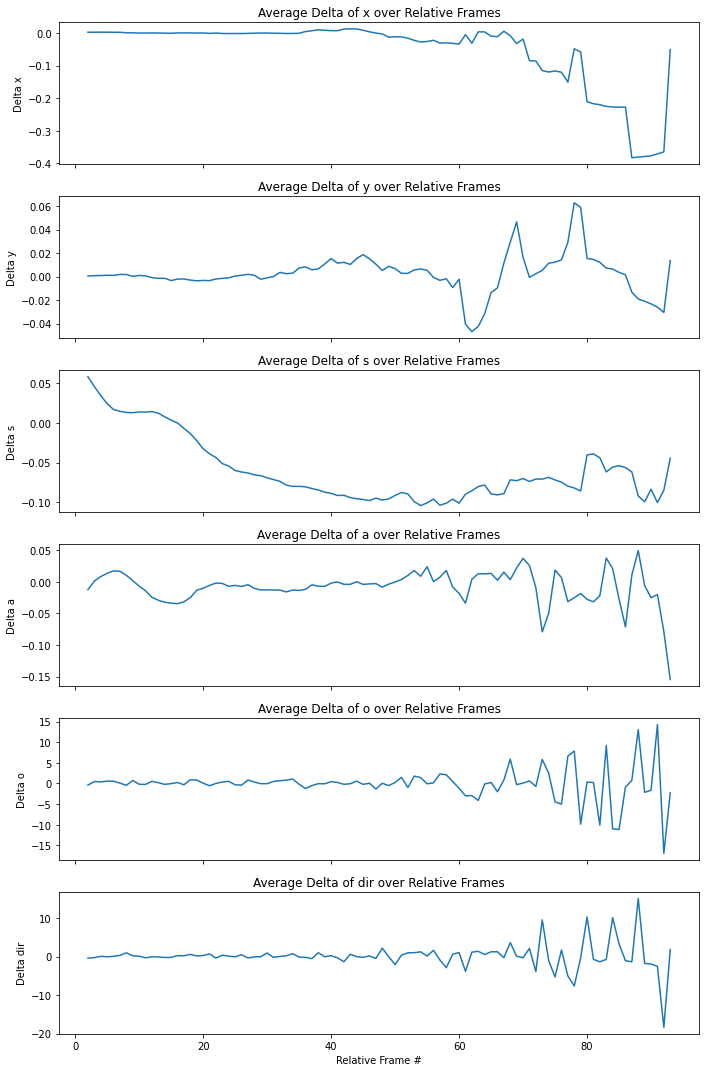

In [22]:
# Visualization
fig, axes = plt.subplots(
    nrows=len(defense_spatial_columns), figsize=(10, 15), sharex=True)

for ax, col in zip(axes, defense_spatial_columns):
    avg_deltas.plot(y=f"delta_{col}", ax=ax, legend=False)
    ax.set_title(f"Average Delta of {col} over Relative Frames")
    ax.set_ylabel(f"Delta {col}")
    ax.set_xlabel("Relative Frame #")

plt.tight_layout()
plt.show()

In [23]:
df

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,ballArrivedFrame,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,passResult,passLength,penaltyYards,prePenaltyPlayResult,playResult,playNullifiedByPenalty,absoluteYardlineNumber,offenseFormation,defendersInTheBox,passProbability,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2,delta_x,delta_y,delta_s,delta_a,delta_o,delta_dir,relative_frame
18,2022090800,56,38577.0,Bobby Wagner,7,2022-09-08 20:24:05.799999,45.0,LA,left,78.10,29.08,3.52,1.83,0.34,345.22,359.37,NaN,6.0,42489,Stefon Diggs,(15:00) (Shotgun) J.Allen pass short right to ...,1,1,10,BUF,LA,BUF,25,15:00,0,0,C,5.0,NaN,6,6,N,85,SHOTGUN,6.0,0.689960,0.413347,0.586653,-0.000031,0.000031,1.298699,0.004420,NaN,NaN,NaN,NaN,-0.01,0.34,0.17,-0.79,-4.25,1.66,2
19,2022090800,56,38577.0,Bobby Wagner,8,2022-09-08 20:24:05.900000,45.0,LA,left,78.10,29.44,3.65,1.16,0.36,342.21,0.37,NaN,6.0,42489,Stefon Diggs,(15:00) (Shotgun) J.Allen pass short right to ...,1,1,10,BUF,LA,BUF,25,15:00,0,0,C,5.0,NaN,6,6,N,85,SHOTGUN,6.0,0.689960,0.413347,0.586653,-0.000031,0.000031,1.298699,0.004420,NaN,NaN,NaN,NaN,0.00,0.36,0.13,-0.67,-3.01,-359.00,3
20,2022090800,56,38577.0,Bobby Wagner,9,2022-09-08 20:24:06.000000,45.0,LA,left,78.11,29.80,3.65,0.61,0.36,343.38,1.93,NaN,6.0,42489,Stefon Diggs,(15:00) (Shotgun) J.Allen pass short right to ...,1,1,10,BUF,LA,BUF,25,15:00,0,0,C,5.0,NaN,6,6,N,85,SHOTGUN,6.0,0.689960,0.413347,0.586653,-0.000031,0.000031,1.298699,0.004420,NaN,NaN,NaN,NaN,0.01,0.36,0.00,-0.55,1.17,1.56,4
21,2022090800,56,38577.0,Bobby Wagner,10,2022-09-08 20:24:06.099999,45.0,LA,left,78.12,30.16,3.64,0.46,0.36,344.37,2.34,NaN,6.0,42489,Stefon Diggs,(15:00) (Shotgun) J.Allen pass short right to ...,1,1,10,BUF,LA,BUF,25,15:00,0,0,C,5.0,NaN,6,6,N,85,SHOTGUN,6.0,0.689960,0.413347,0.586653,-0.000031,0.000031,1.298699,0.004420,NaN,NaN,NaN,NaN,0.01,0.36,-0.01,-0.15,0.99,0.41,5
22,2022090800,56,38577.0,Bobby Wagner,11,2022-09-08 20:24:06.200000,45.0,LA,left,78.15,30.52,3.49,1.06,0.35,347.50,4.79,NaN,6.0,42489,Stefon Diggs,(15:00) (Shotgun) J.Allen pass short right to ...,1,1,10,BUF,LA,BUF,25,15:00,0,0,C,5.0,NaN,6,6,N,85,SHOTGUN,6.0,0.689960,0.413347,0.586653,-0.000031,0.000031,1.298699,0.004420,NaN,NaN,NaN,NaN,0.03,0.36,-0.15,0.60,3.13,2.45,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
928986,2022091200,3826,54618.0,Tariq Woolen,49,2022-09-12 23:05:57.799999,27.0,SEA,left,50.75,6.92,1.88,2.49,0.19,33.48,64.07,tackle,6.0,53464,Javonte Williams,(1:11) (Shotgun) R.Wilson pass short left to J...,4,3,14,DEN,SEA,DEN,45,1:11,17,16,C,-6.0,NaN,9,9,N,65,SHOTGUN,3.0,0.916875,0.508994,0.491006,0.282255,-0.282255,0.967420,-0.719924,NaN,NaN,NaN,NaN,0.17,0.07,-0.06,-0.03,-1.90,-8.71,44
928987,2022091200,3826,54618.0,Tariq Woolen,50,2022-09-12 23:05:57.900000,27.0,SEA,left,50.91,7.01,1.84,2.35,0.18,32.09,55.26,NaN,6.0,53464,Javonte Williams,(1:11) (Shotgun) R.Wilson pass short left to J...,4,3,14,DEN,SEA,DEN,45,1:11,17,16,C,-6.0,NaN,9,9,N,65,SHOTGUN,3.0,0.916875,0.508994,0.491006,0.282255,-0.282255,0.967420,-0.719924,NaN,NaN,NaN,NaN,0.16,0.09,-0.04,-0.14,-1.39,-8.81,45
928988,2022091200,3826,54618.0,Tariq Woolen,51,2022-09-12 23:05:58.000000,27.0,SEA,left,51.06,7.13,1.85,1.98,0.18,32.09,49.15,NaN,6.0,53464,Javonte Williams,(1:11) (Shotgun) R.Wilson pass short left to J...,4,3,14,DEN,SEA,DEN,45,1:11,17,16,C,-6.0,NaN,9,9,N,65,SHOTGUN,3.0,0.916875,0.508994,0.491006,0.282255,-0.282255,0.967420,-0.719924,NaN,NaN,NaN,NaN,0.15,0.12,0.01,-0.37,0.00,-6.11,46
92